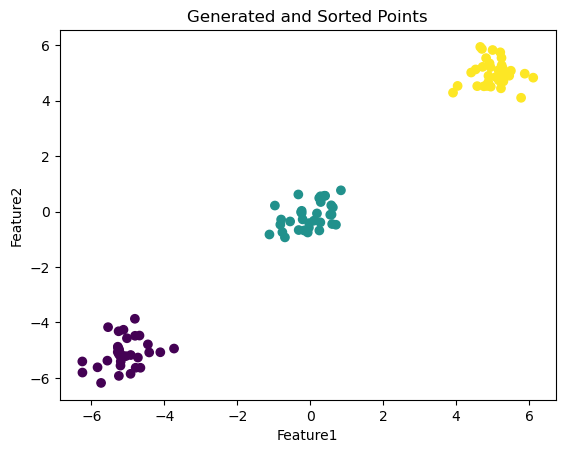

GRID SIZE:  10
Data shape: (99, 2)
p.shape: (99,)
Initialized with NEigs = 100 (type: <class 'int'>)
debugguing eigenvales length is  99
entered lund
Number of Eigenvalues: 99
Number of Eigenvectors: (99, 99)
Shape of G['EigenVecs']: (99, 99)
Shape of G['EigenVals']: (99,)
Shape of DiffusionDistance: (99, 99)
Shape of p: (99,)
m_sorting: [84 19 51 56 59 50 61 62 45 52 43 39 57 54 64 40 35 36 49 42 46 44 53 33
 34 63 38 41 48 65 55 37 47 60 58 68 66 85 75 86 78 81 83 70 79 92 93 87
 97 80 73 74 69 71 72 91 94 88 82 90 98 96 89 76 95 67 77 20 24 23  8 29
  2 31  5 27 28  7 18 16 30  3 17 26  0 15  4 32  1 13  9 10  6 22 12 25
 14 21 11]
Number of clusters K: 3
Number of clusters: 3
GT shape; (99,)
Aligned Accuracy: 1.0


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


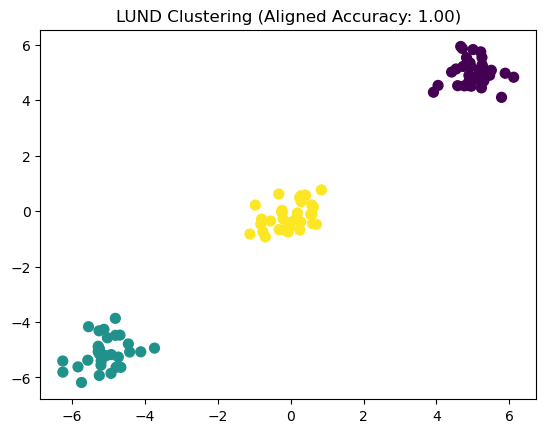

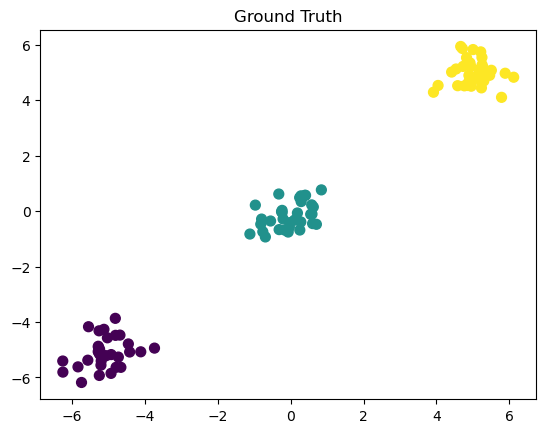

In [3]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_moons, make_blobs, make_classification, make_circles
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor, diffusion_distance
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd

# data_path, gt_path, data_name, gt_name = '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_corrected.mat', '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_gt.mat', 'salinasA_corrected', 'salinasA_gt'


# X, M, N, D, HSI, GT, Y, n, K = loadHSI(data_path, gt_path, data_name, gt_name)
n_samples = 100
n_clusters = 3
centers = [(-5, -5), (0, 0), (5, 5)]
cluster_std = 0.5

# Generate points for each cluster
points = []
labels = []

for i, center in enumerate(centers):
    x = np.random.normal(center[0], cluster_std, n_samples // n_clusters)
    y = np.random.normal(center[1], cluster_std, n_samples // n_clusters)
    cluster_points = np.column_stack((x, y))
    points.append(cluster_points)
    labels.append(np.full(n_samples // n_clusters, i))

points = np.vstack(points)
labels = np.concatenate(labels)

df = pd.DataFrame(points, columns=['Feature1', 'Feature2'])
df['Label'] = labels
df_sorted = df.sort_values(by=['Feature1', 'Feature2']).reset_index(drop=True)

X = df_sorted[['Feature1', 'Feature2']].values
GT = df_sorted['Label'].values

plt.scatter(X[:, 0], X[:, 1], c=GT, cmap='viridis')
plt.title('Generated and Sorted Points')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.show()

scipy.io.savemat('data.mat', {'X': X, 'GT': GT})


grid_size = int(np.ceil(np.sqrt(X.shape[0])))
print("GRID SIZE: ", grid_size)

print("Data shape:", X.shape)

# GT = GT - 1
# HSI = X.reshape((M, N, D))
# Hyperparameters = {
#     'Sigma': 1.0,
#     'DiffusionNN': 10,
    
# }

kde = KernelDensity(bandwidth=1.0)
kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)
print(f'p.shape: {p.shape}')

graph_extractor = GraphExtractor(sigma = 0.5, DiffusionNN = 10)
G = graph_extractor.extract_graph(X)


def plot_diffusion_distance(G, timestep, log_scale=False):
    if log_scale:
        timestep = np.log10(timestep)
    distances, embedding = diffusion_distance(G, timestep)
    plt.figure(figsize=(10, 8))
    sns.heatmap(distances, cmap='viridis')
    plt.title(f'Diffusion Distance Matrix at log10(t)={timestep:.2f}' if log_scale else f'Diffusion Distance Matrix at t={timestep}')
    plt.show()
    
# for timestep in [10, 40, 80, 100]:
#     print(f"Plotting for log10(t)={np.log10(timestep):.2f}")
#     plot_diffusion_distance(G, timestep, log_scale=False)

C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 150, G, p)


# print("Cluster labels:", C)
# print("GT",GT)
print("Number of clusters:", K)

print(f'GT shape; {GT.shape}')
accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    
def plot_kde_density(X, title):
    # Create the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=X[:, 0], y=X[:, 1], cmap='viridis', fill=True, levels=20, thresh=0)
    plt.scatter(X[:, 0], X[:, 1], c='red', s=5, edgecolor='k')
    plt.title(title)
    plt.show()


plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")
# plot_kde_density(X, "KDE Density Estimation")

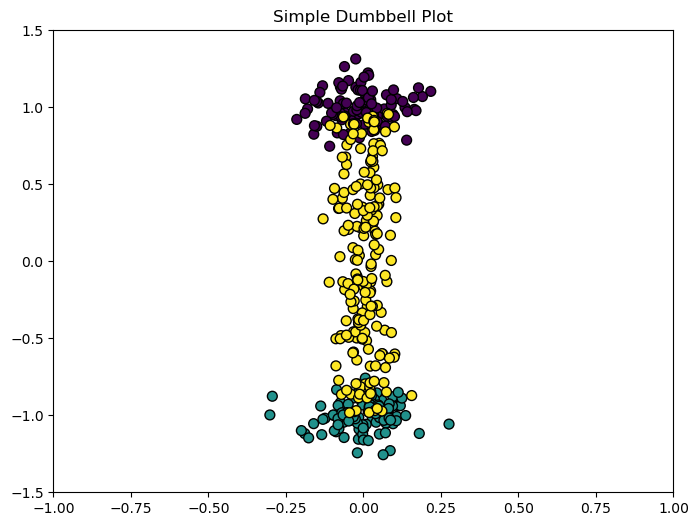

X shape: (400, 2)


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data for the dumbbell
# Top cluster
top_cluster = np.column_stack((np.random.normal(loc=0, scale=0.1, size=100), 
                               np.random.normal(loc=1, scale=0.1, size=100)))
# Bottom cluster
bottom_cluster = np.column_stack((np.random.normal(loc=0, scale=0.1, size=100), 
                                  np.random.normal(loc=-1, scale=0.1, size=100)))
# Handle
handle = np.column_stack((np.random.normal(loc=0, scale=0.05, size=200), 
                          np.random.uniform(low=-1, high=1, size=200)))

# Combine all parts
X = np.vstack((top_cluster, bottom_cluster, handle))
labels = np.array([0]*100 + [1]*100 + [2]*200)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, edgecolor='k')
plt.title('Simple Dumbbell Plot')
plt.xlim(-1, 1)
plt.ylim(-1.5, 1.5)
plt.show()

print("X shape:", X.shape)

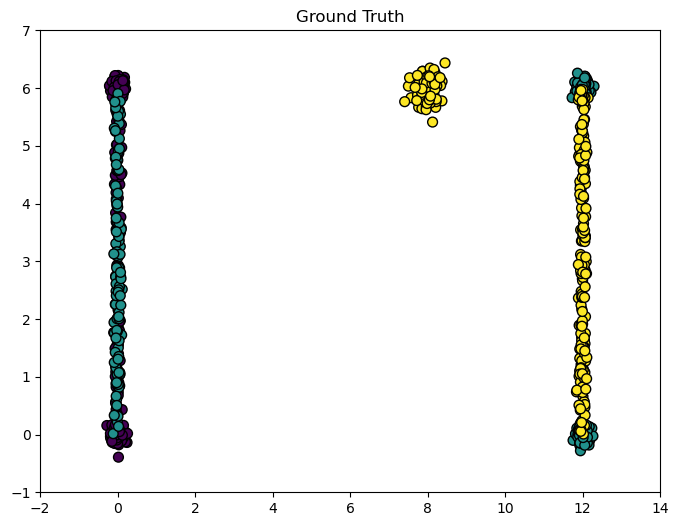

X shape: (900, 2)
labels shape: (900,)


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Function to generate a dumbbell shape
def generate_dumbbell(x_center, y_top, y_bottom, size=100):
    top_cluster = np.column_stack((np.random.normal(loc=x_center, scale=0.1, size=size), 
                                   np.random.normal(loc=y_top, scale=0.1, size=size)))
    bottom_cluster = np.column_stack((np.random.normal(loc=x_center, scale=0.1, size=size), 
                                      np.random.normal(loc=y_bottom, scale=0.1, size=size)))
    handle = np.column_stack((np.random.normal(loc=x_center, scale=0.05, size=size*2), 
                              np.random.uniform(low=y_bottom, high=y_top, size=size*2)))
    return np.vstack((top_cluster, bottom_cluster, handle))

# Generate data for the dumbbells
dumbbell_1 = generate_dumbbell(x_center=0, y_top=6, y_bottom=0)
dumbbell_2 = generate_dumbbell(x_center=12, y_top=6, y_bottom=0)
center_cluster = np.column_stack((np.random.normal(loc=8, scale=0.2, size=100), 
                                  np.random.normal(loc=6, scale=0.2, size=100)))

# Combine all clusters
X = np.vstack((dumbbell_1, dumbbell_2, center_cluster))
labels = np.array([0]*300 + [1]*300 + [2]*300)

# Plot the data with clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, edgecolor='k')
plt.title('Ground Truth')
plt.xlim(-2, 14)
plt.ylim(-1, 7)
plt.show()

print("X shape:", X.shape)
print("labels shape:", labels.shape)